## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [2]:
import os
import tensorflow.keras as keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

/Users/ttyoung/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
x_train = x_train[:5000]
x_test = x_test[:5000]
y_train = y_train[:5000]
y_test = y_test[:5000]

In [13]:
from tensorflow.keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [14]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [15]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L1_EXP:
    try:
        keras.backend.clear_session() # 把舊的 Graph 清掉
    except:
        pass
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 5000 samples, validate on 5000 samples
Epoch 1/50
5000/5000 [=========================

Train on 5000 samples, validate on 5000 samples
Epoch 1/50
5000/5000 [==============================] - 1s 282us/step - loss: 6.2821 - acc: 0.1296 - val_loss: 6.2191 - val_acc: 0.1816
Epoch 2/50
5000/5000 [==============================] - 1s 197us/step - loss: 6.1589 - acc: 0.2224 - val_loss: 6.1177 - val_acc: 0.2248
Epoch 3/50
5000/5000 [==============================] - 1s 197us/step - loss: 6.0626 - acc: 0.2630 - val_loss: 6.0300 - val_acc: 0.2776
Epoch 4/50
5000/5000 [==============================] - 1s 197us/step - loss: 5.9822 - acc: 0.2958 - val_loss: 5.9710 - val_acc: 0.2970
Epoch 5/50
5000/5000 [==============================] - 1s 197us/step - loss: 5.9187 - acc: 0.3158 - val_loss: 5.9212 - val_acc: 0.3096
Epoch 6/50
5000/5000 [==============================] - 1s 196us/step - loss: 5.8718 - acc: 0.3232 - val_loss: 5.8798 - val_acc: 0.3350
Epoch 7/50
5000/5000 [==============================] - 1s 197us/step - loss: 5.8321 - acc: 0.3396 - val_loss: 5.8533 - val_acc: 0.3310


5000/5000 [==============================] - 1s 199us/step - loss: 2.1873 - acc: 0.2136 - val_loss: 2.1522 - val_acc: 0.2436
Epoch 3/50
5000/5000 [==============================] - 1s 195us/step - loss: 2.1008 - acc: 0.2476 - val_loss: 2.0798 - val_acc: 0.2612
Epoch 4/50
5000/5000 [==============================] - 1s 196us/step - loss: 2.0287 - acc: 0.2874 - val_loss: 2.0249 - val_acc: 0.2802
Epoch 5/50
5000/5000 [==============================] - 1s 194us/step - loss: 1.9716 - acc: 0.3008 - val_loss: 1.9751 - val_acc: 0.3054
Epoch 6/50
5000/5000 [==============================] - 1s 196us/step - loss: 1.9231 - acc: 0.3218 - val_loss: 1.9353 - val_acc: 0.3106
Epoch 7/50
5000/5000 [==============================] - 1s 196us/step - loss: 1.8838 - acc: 0.3334 - val_loss: 1.9137 - val_acc: 0.3232
Epoch 8/50
5000/5000 [==============================] - 1s 197us/step - loss: 1.8543 - acc: 0.3400 - val_loss: 1.8905 - val_acc: 0.3324
Epoch 9/50
5000/5000 [==============================] - 1s 

5000/5000 [==============================] - 1s 204us/step - loss: 2.0301 - acc: 0.2808 - val_loss: 2.0218 - val_acc: 0.2836
Epoch 5/50
5000/5000 [==============================] - 1s 225us/step - loss: 1.9699 - acc: 0.3040 - val_loss: 1.9769 - val_acc: 0.2994
Epoch 6/50
5000/5000 [==============================] - 1s 210us/step - loss: 1.9241 - acc: 0.3234 - val_loss: 1.9444 - val_acc: 0.3170
Epoch 7/50
5000/5000 [==============================] - 1s 240us/step - loss: 1.8886 - acc: 0.3430 - val_loss: 1.9125 - val_acc: 0.3298
Epoch 8/50
5000/5000 [==============================] - 1s 219us/step - loss: 1.8549 - acc: 0.3562 - val_loss: 1.8904 - val_acc: 0.3368
Epoch 9/50
5000/5000 [==============================] - 1s 210us/step - loss: 1.8273 - acc: 0.3622 - val_loss: 1.8694 - val_acc: 0.3448
Epoch 10/50
5000/5000 [==============================] - 1s 248us/step - loss: 1.8038 - acc: 0.3732 - val_loss: 1.8508 - val_acc: 0.3468
Epoch 11/50
5000/5000 [==============================] - 1

In [16]:
import matplotlib.colors as colors
colors_list = list(colors._colors_full_map.values())


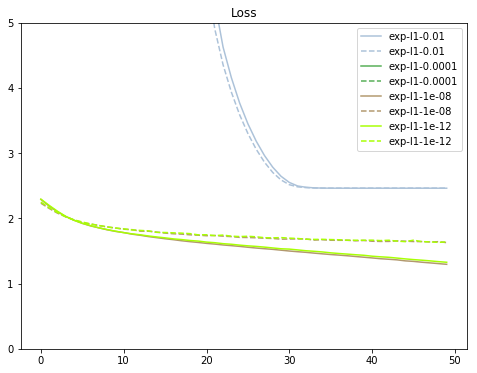

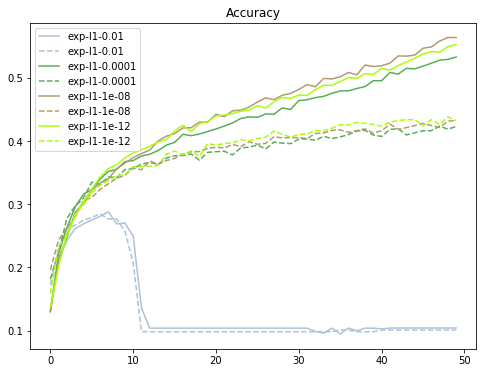

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = colors_list

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()